In [1]:
import os
import cv2
import time
import math
import torch
import argparse
import numpy as np
import pandas as pd
from nets.LeafPoseNet import LeafPoseNet
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
def adjust_image(image, fixed_size):
    h, w, c = image.shape
    hw_ratio = fixed_size[0] / fixed_size[1]
    if h / w > hw_ratio:
        pad = int(((h / hw_ratio) - w) / 2)
        new_image = np.zeros((h, w + 2 * pad, c))
        new_image[:, pad:w + pad, :] = image
    elif h / w < hw_ratio:
        pad = int(((w * hw_ratio) - h) / 2)
        new_image = np.zeros((h + 2 * pad, w, c))
        new_image[pad:h + pad, :, :] = image
    else:
        new_image = image
    return new_image

# Image preprocessing
def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (576, 768), interpolation=cv2.INTER_NEAREST)
    img_resized = cv2.resize(img, (288, 384), interpolation=cv2.INTER_NEAREST)
    img_norm = img / 255.0
    mean = [0.501642, 0.517964, 0.514330]
    std = [0.139957, 0.155858, 0.153716]
    img_norm = (img_norm - mean) / std
    img_tensor = torch.from_numpy(img_norm.transpose(2, 0, 1)).unsqueeze(0).float()
    return img_tensor, img_resized

mean = [0.501642, 0.517964, 0.514330]
std = [0.139957, 0.155858, 0.153716]
fixed_size = (768, 576)

In [3]:
# ======== Load model and select device ========
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
model = LeafPoseNet()
weights = torch.load("weights/best.pth", map_location=device)
weights = weights if "model" not in weights else weights["model"]
model.load_state_dict(weights)
model.to(device)
model.eval()


🚀 Using device: cuda:0


LeafPoseNet(
  (first): Sequential(
    (0): convbnrelu(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): convbnrelu(
      (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stage): ModuleList(
    (0): Sequential(
      (0): SuperInvBottleneck(
        (conv): Sequential(
          (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
  

In [4]:
# ======== Paths and settings ========
image_dir = "datasets/images"  # Path to the directory of input images
model_path = "weights/best.pth"                         # Path to trained LeafPoseNet weights (.pth)
output_csv = "output/predict_result.csv"                     # Output path for the CSV file


# ======== Initialize result table ========
data = pd.DataFrame(columns=['Image_Name', 'Angle', 'x0', 'x1', 'x2', 'y0', 'y1', 'y2'])

start_time = time.time()
num = 0

with torch.no_grad():
    image_list = [f for f in os.listdir(image_dir)
                    if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))]

    for img_name in tqdm(image_list, desc="🔍 Predicting", unit="img"):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping unreadable image: {img_name}")
            continue

        num += 1
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img.shape[0] < img.shape[1]:
            img = cv2.transpose(img)[::-1, :, :]
        img = adjust_image(img, fixed_size)
        img = cv2.resize(img, (576, 768))
        img = (img / 255 - mean) / std
        img_t = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

        outputs = model(img_t)
        b, n, h, w = outputs.shape
        heatmaps = outputs.view(b, n, -1)
        maxvals, idx = torch.max(heatmaps, dim=2)
        idx = idx.float()
        x_v = idx[0] % w
        y_v = torch.floor(idx[0] / w)
        preds = torch.cat((x_v, y_v), dim=0) * 2
        pred_np = preds.cpu().numpy()

        # Calculate angle
        if pred_np[5] - pred_np[4] < 0:
            vector_A = [pred_np[2] - pred_np[1], pred_np[5] - pred_np[4]]
        else:
            vector_A = [pred_np[1] - pred_np[2], pred_np[4] - pred_np[5]]
        vector_B = [pred_np[0] - pred_np[1], pred_np[3] - pred_np[4]]
        dot_product = sum(a * b for a, b in zip(vector_A, vector_B))
        mag_A = math.sqrt(sum(a ** 2 for a in vector_A))
        mag_B = math.sqrt(sum(b ** 2 for b in vector_B))
        angle_rad = math.acos(dot_product / (mag_A * mag_B))
        angle_deg = math.degrees(angle_rad)

        # Save one row to result
        temp_df = pd.DataFrame({
            'Image_Name': [img_name[:-4]],
            'Angle': [angle_deg],
            'x0': [pred_np[0]], 'x1': [pred_np[1]], 'x2': [pred_np[2]],
            'y0': [pred_np[3]], 'y1': [pred_np[4]], 'y2': [pred_np[5]]
        })
        data = pd.concat([data, temp_df], ignore_index=True)

# ======== Save results ========
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
data.to_csv(output_csv, index=False)
total_time = time.time() - start_time

print(f"\n✅ Finished! Processed {num} images in {total_time:.2f} seconds.")
print(f"📄 CSV results saved to: {output_csv}")


🔍 Predicting: 100%|██████████| 10/10 [00:01<00:00,  9.21img/s]


✅ Finished! Processed 10 images in 1.09 seconds.
📄 CSV results saved to: output/predict_result.csv


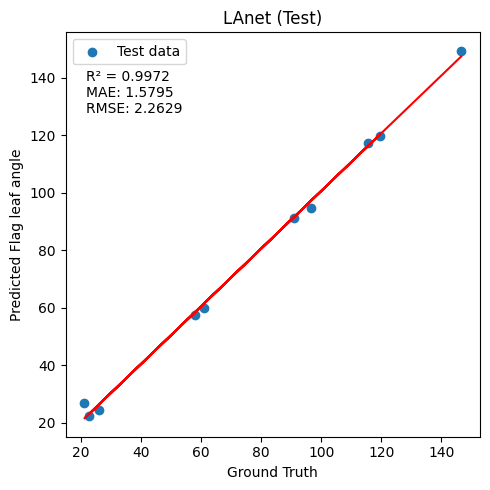

In [5]:


# Read true and predicted data
true_data = pd.read_excel('datasets/labels/labels.xlsx')
pred_data = pd.read_csv('output/predict_result.csv')
#print(true_data)
#print(pred_data)
# Merge the data on Image_Name, keeping only rows present in both files
merged_data = pd.merge(true_data[['img_name', 't_angle']], pred_data[['Image_Name', 'Angle']] , left_on='img_name', right_on='Image_Name')
#print(merged_data)
# Function to plot regression results
def plot_regression_results(data, group_name):
    x = data['t_angle']
    y = data['Angle']

    plt.scatter(x, y, label=f'{group_name} data')

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot regression line
    plt.plot(x, slope * x + intercept, color='red')

    # Calculate regression model evaluation metrics
    mse = mean_squared_error(x, y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Display evaluation metrics on the plot
    metrics_text = f'R² = {r2:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.text(0.05, 0.8, metrics_text, transform=plt.gca().transAxes, color='black')

    # Set labels and title
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted Flag leaf angle')
    plt.title(f'LeafPoseNet ({group_name})')

    # Display legend
    plt.legend()
# Create a figure to display results
plt.figure(figsize=(5, 5))

# Plot test data results

plot_regression_results(merged_data, 'Test')

# Show the plot
plt.tight_layout()
plt.show()


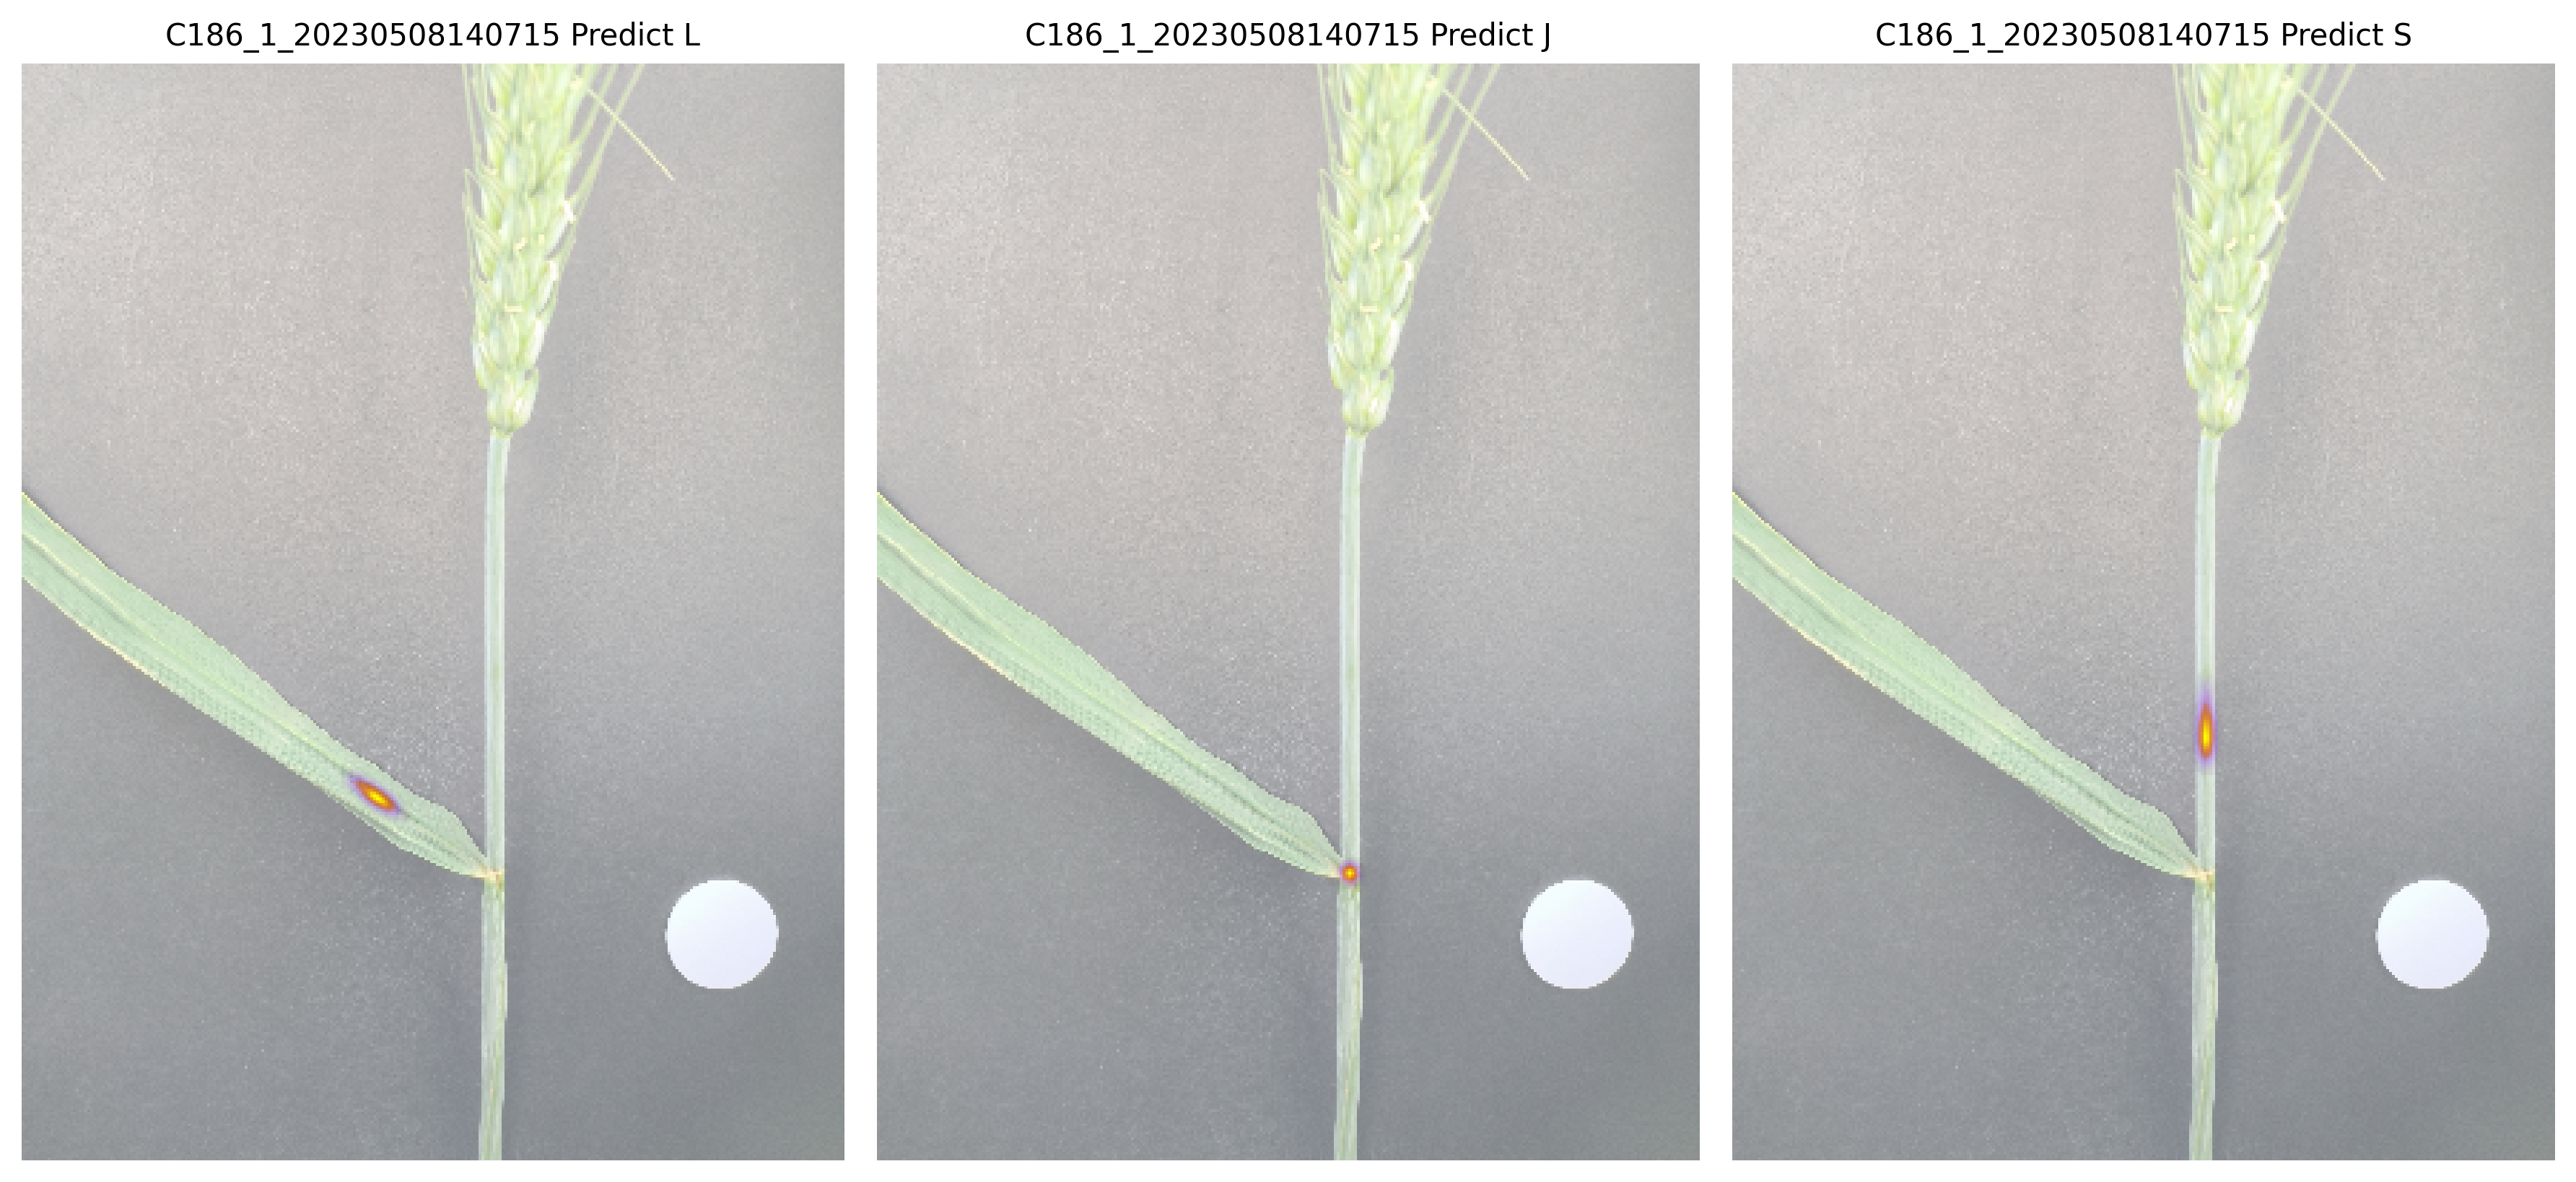

In [13]:
image_dir = 'datasets/images/'
target_image_name = 'C186_1_20230508140715'
img_path = f"{image_dir}{target_image_name}.jpg"
# Run inference
img_tensor, img_resized = preprocess_image(img_path)

img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor).cpu().numpy()


# Extract heatmaps and predicted coordinates
heatmaps = [output[0, i] for i in range(3)]
coords = [np.unravel_index(np.argmax(hm), hm.shape) for hm in heatmaps]
coords = [(x * (576 / hm.shape[1]), y * (768 / hm.shape[0])) for (y, x), hm in zip(coords, heatmaps)]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 9), dpi=300)
titles = ['Predict L', 'Predict J', 'Predict S']

for i, ax in enumerate(axes):
    heatmap = heatmaps[i]
    alpha = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    ax.imshow(img_resized, alpha=0.6)
    ax.imshow(heatmap, cmap='gnuplot', alpha=alpha)
    ax.set_title(f'{target_image_name} {titles[i]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()